## Persistent homology - Vectorisation

It is common in the field of topological data analysis to use information from persistent homology to train machine learning (ML) models classification tasks. For example it has been used to 
quantify structural heterogenity of extracellular matrix in lung adenocarcinoma (https://doi.org/10.1101/2024.01.05.574362) and used to identify the three E's of immunoediting in solid tumours using macrophage patterning (https://doi.org/10.1007/s11538-024-01353-6).

However, outputs from persistent homology cannot be directly used in ML as their structure contains subtle information about the relations between topological features. A typical method of transforming these outputs for ML is vectorisation, which seeks to summarise the information stored within the persistence diagrams into a single vector by extracting specific properties of this landscape. For more information on vectorisation, see https://arxiv.org/pdf/2212.09703.

We can vectorise our persistent homology analysis in MuSpAn using our `vectorise_persistence` function. In this tutorial, we'll briefly demonstrate it's use.

MuSpAn domain loaded successfully. Domain summary:
Domain name: Density
Number of objects: 2000
Collections: ['Cell centres']
Labels: ['Celltype'] 
Networks: [] 
Distance matrices: []
MuSpAn domain loaded successfully. Domain summary:
Domain name: Aggregation
Number of objects: 2000
Collections: ['Cell centres']
Labels: ['Celltype'] 
Networks: [] 
Distance matrices: []
MuSpAn domain loaded successfully. Domain summary:
Domain name: Exclusion
Number of objects: 2166
Collections: ['Cell centres']
Labels: ['Celltype'] 
Networks: [] 
Distance matrices: []
MuSpAn domain loaded successfully. Domain summary:
Domain name: Architecture
Number of objects: 5991
Collections: ['Cell centres']
Labels: ['Celltype'] 
Networks: [] 
Distance matrices: []


Text(0.5, 1.0, 'Architecture')

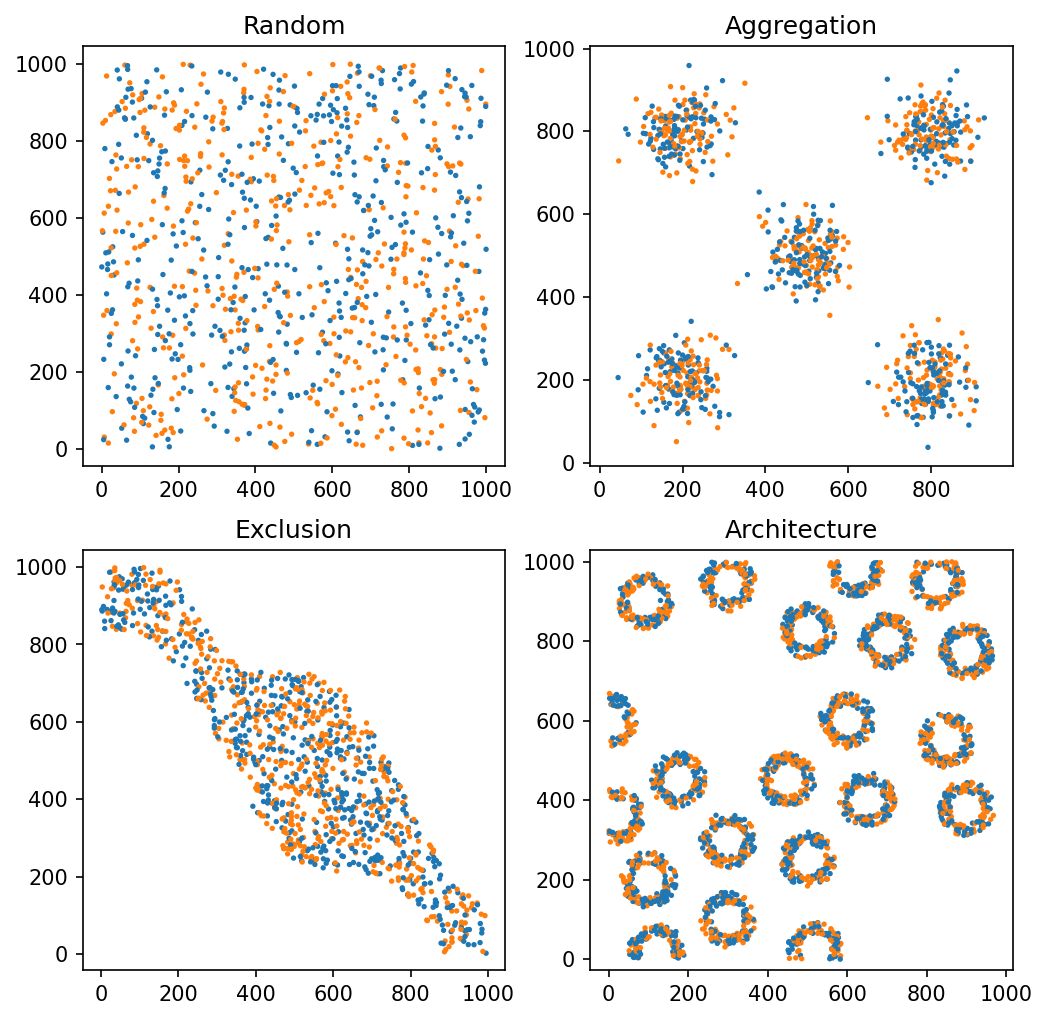

In [1]:
import muspan as ms
import matplotlib.pyplot as plt

# Set the resolution of the plots
plt.rcParams['figure.dpi'] = 150

domain_1=ms.datasets.load_example_domain('Synthetic-Points-Random')
domain_2=ms.datasets.load_example_domain('Synthetic-Points-Aggregation')
domain_3=ms.datasets.load_example_domain('Synthetic-Points-Exclusion')
domain_4=ms.datasets.load_example_domain('Synthetic-Points-Architecture')

# Query to select objects of type 'A' or 'B' in each domain
q_A_or_B_rand = ms.query.query(domain_1, ('label', 'Celltype'), 'in', ['A', 'B'])
q_A_or_B_agg = ms.query.query(domain_2, ('label', 'Celltype'), 'in', ['A', 'B'])
q_A_or_B_ex = ms.query.query(domain_3, ('label', 'Celltype'), 'in', ['A', 'B'])
q_A_or_B_arch = ms.query.query(domain_4, ('label', 'Celltype'), 'in', ['A', 'B'])

# Create a figure with 2x2 subplots
fig, ax = plt.subplots(2, 2, figsize=(8, 8), gridspec_kw={'hspace': 0.2})

# Visualize the 'Random' domain
ms.visualise.visualise(domain_1, 'Celltype', ax=ax[0, 0], add_cbar=False, marker_size=2.5, objects_to_plot=q_A_or_B_rand)
ax[0, 0].set_title('Random')

# Visualize the 'Aggregation' domain
ms.visualise.visualise(domain_2, 'Celltype', ax=ax[0, 1], add_cbar=False, marker_size=2.5, objects_to_plot=q_A_or_B_agg)
ax[0, 1].set_title('Aggregation')

# Visualize the 'Exclusion' domain
ms.visualise.visualise(domain_3, 'Celltype', ax=ax[1, 0], add_cbar=False, marker_size=2.5, objects_to_plot=q_A_or_B_ex)
ax[1, 0].set_title('Exclusion')

# Visualize the 'Architecture' domain
ms.visualise.visualise(domain_4, 'Celltype', ax=ax[1, 1], add_cbar=False, marker_size=2.5, objects_to_plot=q_A_or_B_arch)
ax[1, 1].set_title('Architecture')

As shown in our previous tutorial (Persistent homology - Vietoris-Rips filtration), we'll run a Veitoris-Rips filtration on the points with labels A and B in each of the domains using our `vietoris_rips_filtration`. We'll also visualise the diagrams of these filtrations.

Text(0.5, 1.0, 'Architecture')

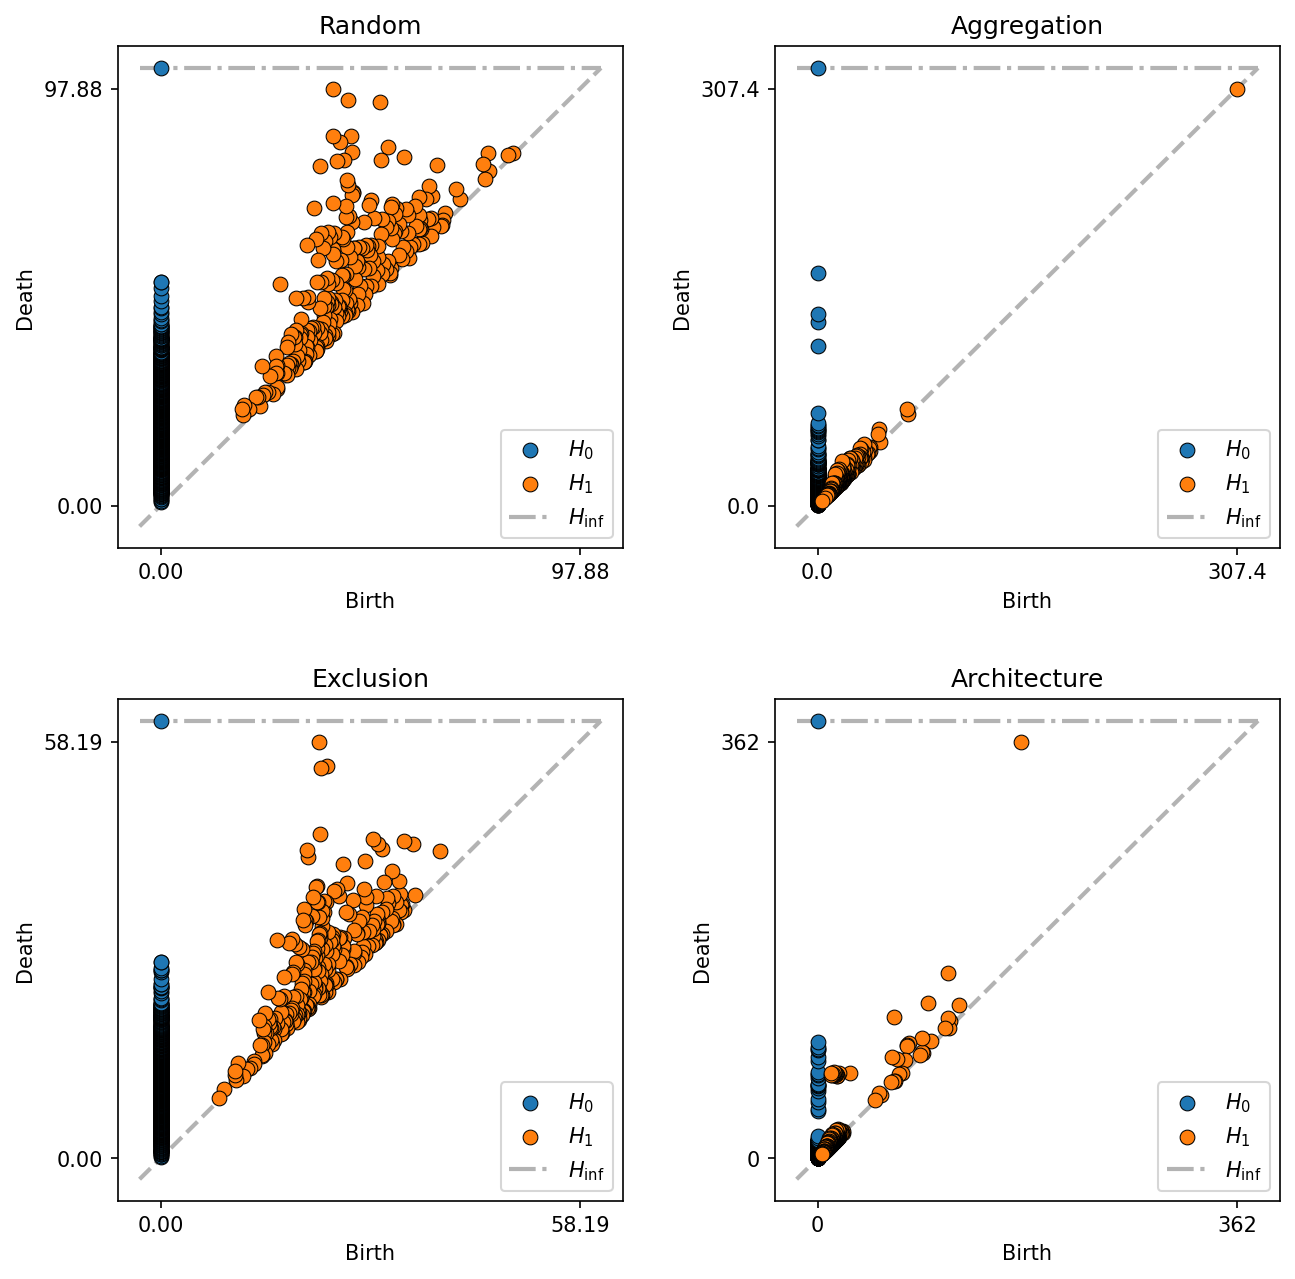

In [2]:
# Compute Vietoris-Rips filtrations for each domain
feature_persistence_1 = ms.topology.vietoris_rips_filtration(domain_1, population=q_A_or_B_rand, max_dimension=1)
feature_persistence_2 = ms.topology.vietoris_rips_filtration(domain_2, population=q_A_or_B_agg, max_dimension=1)
feature_persistence_3 = ms.topology.vietoris_rips_filtration(domain_3, population=q_A_or_B_ex, max_dimension=1)
feature_persistence_4 = ms.topology.vietoris_rips_filtration(domain_4, population=q_A_or_B_arch, max_dimension=1)

# Create a figure with 2x2 subplots to visualize the persistence diagrams
fig, ax = plt.subplots(2, 2, figsize=(10, 10), gridspec_kw={'wspace': 0.3, 'hspace': 0.3})

# Visualize the persistence diagram for the 'Random' domain
ms.visualise.persistence_diagram(feature_persistence_1, ax=ax[0, 0])
ax[0, 0].set_title('Random')

# Visualize the persistence diagram for the 'Aggregation' domain
ms.visualise.persistence_diagram(feature_persistence_2, ax=ax[0, 1])
ax[0, 1].set_title('Aggregation')

# Visualize the persistence diagram for the 'Exclusion' domain
ms.visualise.persistence_diagram(feature_persistence_3, ax=ax[1, 0])
ax[1, 0].set_title('Exclusion')

# Visualize the persistence diagram for the 'Architecture' domain
ms.visualise.persistence_diagram(feature_persistence_4, ax=ax[1, 1])
ax[1, 1].set_title('Architecture')

Now we have some outputs from persistent homology in MuSpAn, let's vectorise these using the `vectorise_persistence` function. Guided by the results of Ali et al. (https://arxiv.org/pdf/2212.09703), we'll use the summary statistics method for vectorisation.

Namely, for all dimensions, calculate the following statistics:
(1) The number of features (points on diagram). (2) The mean, standard deviation, 10th, 25th, 50th, 75th and 90th percentiles of the births (p), the deaths (q), lifespans (p-q), and midpoints of the bars (p-q)/2. (3) Entropy of the peristence of features.
 
This produces a vector of 30*(max-dimension). We call this method by using the `method='statistics'` parameter. In addition, the function also returns an ordered list of the features in the vector. Let's check this is the case when applying this vectorisation.


In [3]:
# Vectorise the persistence diagram for the 'Random' domain using statistical method
vectorised_ph_1,name_of_features = ms.topology.vectorise_persistence(feature_persistence_1, method='statistics')

# Print the vectorised persistence homology for the 'Random' domain
print('Length of vector: ', len(vectorised_ph_1))

# Print the vectorised persistence homology for the 'Random' domain
print('Vectorised PH of random: ', vectorised_ph_1)

# Print the name of features
print('Name of features: ', name_of_features)

Length of vector:  60
Vectorised PH of random:  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.08278029e+01
 9.89409111e+00 8.09930134e+00 1.33143249e+01 2.03376160e+01
 2.75385628e+01 3.40955650e+01 1.04139015e+01 4.94704556e+00
 4.04965067e+00 6.65716243e+00 1.01688080e+01 1.37692814e+01
 1.70477825e+01 2.08278029e+01 9.89409111e+00 8.09930134e+00
 1.33143249e+01 2.03376160e+01 2.75385628e+01 3.40955650e+01
 1.00000000e+03 6.90675478e+00 4.36732208e+01 1.18986665e+01
 2.96763222e+01 3.57827148e+01 4.23845177e+01 5.11732826e+01
 6.03805168e+01 5.36715146e+01 1.58086848e+01 3.32118896e+01
 4.06427345e+01 5.38748436e+01 6.50349655e+01 7.31376266e+01
 4.86723677e+01 1.29766957e+01 3.17512789e+01 3.87056866e+01
 4.91162167e+01 5.90540276e+01 6.49401569e+01 9.99829372e+00
 1.04597818e+01 8.80110931e-01 2.58813858e+00 6.55965424e+00
 1.33480225e+01 2.43299271e+01 2.57000000e+02 5.54907608e+00]
Name of features:  ['H0 birth mean',

In this form, this vectorisation can be used to compare various spatial datasets using persistent homology, or fed into a larger feature vector for ML classification tasks. Let's see what these vectors might look like for all our synthetic domains using dimensionality reduction.

Text(0.5, 1.0, 'PCA of Vectorised Persistence Diagrams')

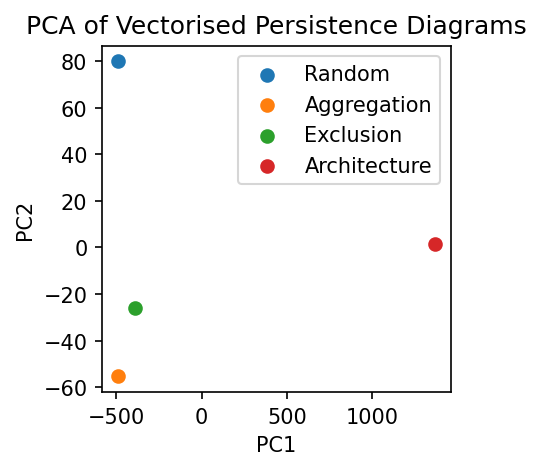

In [5]:
from sklearn.decomposition import PCA
import numpy as np

# Vectorise the persistence diagrams for each domain using the statistical method
vectorised_ph_1,_ = ms.topology.vectorise_persistence(feature_persistence_1, method='statistics')
vectorised_ph_2,_ = ms.topology.vectorise_persistence(feature_persistence_2, method='statistics')
vectorised_ph_3,_ = ms.topology.vectorise_persistence(feature_persistence_3, method='statistics')
vectorised_ph_4,_ = ms.topology.vectorise_persistence(feature_persistence_4, method='statistics')

# Combine all vectorised persistence diagrams into a single array
vectorised_ph_all = np.vstack([vectorised_ph_1, vectorised_ph_2, vectorised_ph_3, vectorised_ph_4])

# Perform PCA to reduce the dimensionality to 2 components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(vectorised_ph_all)

# Plot the PCA result
fig, ax = plt.subplots(figsize=(3, 3))
ax.scatter(pca_result[0, 0], pca_result[0, 1], label='Random')
ax.scatter(pca_result[1, 0], pca_result[1, 1], label='Aggregation')
ax.scatter(pca_result[2, 0], pca_result[2, 1], label='Exclusion')
ax.scatter(pca_result[3, 0], pca_result[3, 1], label='Architecture')

# Add labels and title to the plot
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.title('PCA of Vectorised Persistence Diagrams')


Projecting the vectorisation of these diagrams into 2-dimension PCA space, we can see that the structure of A and B points observed in all four domains are different. The closest pair are the exclusion and aggregation domains as they contain unstructed but clustered points. Whereas architecture contains many loops and is highly separated on the x-axis, indicating PC1 relates to H1 persistence. In summary, this highlights that this vectorisation is retaining the relevant homological information to delineate between these domains.

There are many other ways of vectorising persistent homology outputs. We recommend checking out our documentation on `persistence_vectorisation` and if you think we're missing an interesting vectorisation, let us know at info@muspan.co.uk and we can add it in!